In [2]:
import warnings
warnings.filterwarnings('ignore')

# 필수 라이브러리 임포트
import os
import torch
import numpy as np
from datetime import datetime
from datasets import load_dataset

# Transformers 라이브러리
from transformers import (
    pipeline,                              # 고수준 API - 가장 쉬운 방법 / 자동화시킴 // 토커나이즈, 모델로 추론 --> 파이프라인이 다해줌. (머신러닝처럼 필요한것 다 적을필요 없음..)
    AutoTokenizer,                         # 자동 토크나이저
    AutoModelForQuestionAnswering,         # QA 모델 자동 로더
    DistilBertTokenizerFast,              # DistilBERT 고속 토크나이저 FAST 파이썬말고 다른걸로..고속기능..
    DistilBertForQuestionAnswering,        # DistilBERT QA 모델
    ElectraTokenizer,                      # ELECTRA 토크나이저 (한글)
    ElectraForQuestionAnswering,           # ELECTRA QA 모델 (한글)
    DefaultDataCollator,                   # 기본 데이터 콜레이터
    TrainingArguments,                     # 학습 하이퍼파라미터
    Trainer                               # 범용 트레이너
)

In [5]:
# pipeline
# AutoModel
# SQuAD 데이터셋 확인
# Fine-tuning 데이터 전처리
# Fine-tuning 학습
# 한글 질의 응답

### <span style="color: Gold"> **pipeline**

In [ ]:
#### pipeline
question_answer = pipeline(                         # 토커나이즈, 모델로 추론 --> 파이프라인이 다해줌.
    "question-answering",
    model='distilbert-base-cased-distilled-squad'
)


context = """Text mining, also referred to as text data mining (abbr.: TDM), similar to text analytics, 
is the process of deriving high-quality information from text. It involves 
"the discovery by computer of new, previously unknown information, 
by automatically extracting information from different written resources." 
Written resources may include websites, books, emails, reviews, and articles. 
High-quality information is typically obtained by devising patterns and trends 
by means such as statistical pattern learning. According to Hotho et al. (2005)
we can distinguish between three different perspectives of text mining: 
information extraction, data mining, and a KDD (Knowledge Discovery in Databases) process."""

question1 = "What is text mining?"
question2 = "What are the perspectives of text mining?"


# 질의 응답 수행
answer1= question_answer(context=context, question=question1)
answer2= question_answer(context=context, question=question2)
if answer1['score'] < 0.1:
    print(f" answer1 : 답변없음 {answer1['score']}")
else:
    print(f' answer1 : {answer1}')

if answer2['score'] < 0.1:
    print(f" answer1 : 답변없음{answer2['score']:.4f}")
else:
    print(f' answer2 : {answer2}')

# score == 신뢰도 ---> 임계치를 0.5로 봐서? 임계치보다 낮으면 신뢰도가 낮다고 봄.
# 그래서 원래는... score 를 0.5 로 했으나.. answer1이 0.4라서.. 0.1로 바꿈
# 실무에서는 0.7~0.8로 지정함

Device set to use cpu


 answer1 : {'score': 0.42419007420539856, 'start': 95, 'end': 153, 'answer': 'the process of deriving high-quality information from text'}
 answer1 : 답변없음0.0456


### <span style="color: Gold"> **AutoModel**

In [ ]:
###### AutoModel ==> 여기서 작성한 모든게 위에서는 pipeline 한줄로 다 가능함.
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-cased-distilled-squad')
model = AutoModelForQuestionAnswering.from_pretrained('distilbert-base-cased-distilled-squad')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

inputs = tokenizer(question1, context, return_tensors = 'pt').to(device)
with torch.no_grad():
    outputs = model(**inputs)
start_score = outputs.start_logits
end_score = outputs.end_logits
answer_start = torch.argmax(start_score) #가장높은값의 인덱스를 알아야하므로 argmax (arg가 인덱스)
answer_end = torch.argmax(end_score)
answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0][answer_start:answer_end+1]))
# tokens_to_string : token 단위로 된 문자들을 문장으로 이어줌
# convert_ids_to_tokens : ids 를 토큰 문자로 변경  1, 2, 3 --> paris, is, 이런식
# answer_start:answer_end+1 : 슬라이싱 [:]인데, 만약 결과가 paris 단어 하나면 [1:1] 로 되어 출력안되므로 +1 해줌
print(f"answer1 : {answer}")

answer1 : the process of deriving high - quality information from text


### <span style="color: Gold"> **SQuAD**
- Stanford Question Answering Dataset
- “질문 + 문맥 + 답변 위치”로 이루어진 QA 데이터셋

In [5]:
#### SQuAD 데이터셋 로드 분석
# 스탠포드 대학에서 공개한 질의응답 벤치마크 - Extraction QA 표준
squad = load_dataset('squad', split ='train[:5000]')
squad = squad.train_test_split(test_size=0.2, seed=42)
print(squad)

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1000
    })
})


In [23]:
print(squad['train'][0])   #key, value 형식으로 출력됨. 0,1,2 인덱스에 따라서 4000개가 들어있음
print(squad['train'][0].keys())
print(squad['train'][0]['context'][:100])   #문장
print(squad['train'][0]['question'][:100])   # 질문
print(squad['train'][0]['answers'])  #정답
print(squad['train'][0]['context'][98:98+len('Neo-Confucian establishment')])  #정답이 맞는지 확인..

{'id': '56ce362faab44d1400b885c7', 'title': 'Sino-Tibetan_relations_during_the_Ming_dynasty', 'context': "With the death of Zhengde and ascension of Jiajing, the politics at court shifted in favor of the Neo-Confucian establishment which not only rejected the Portuguese embassy of Fernão Pires de Andrade (d. 1523), but had a predisposed animosity towards Tibetan Buddhism and lamas. Evelyn S. Rawski, a professor in the Department of History of the University of Pittsburgh, writes that the Ming's unique relationship with Tibetan prelates essentially ended with Jiajing's reign while Ming influence in the Amdo region was supplanted by the Mongols.", 'question': 'What establishment did the politics at court shift in favor of? ', 'answers': {'text': ['Neo-Confucian establishment'], 'answer_start': [98]}}
dict_keys(['id', 'title', 'context', 'question', 'answers'])
With the death of Zhengde and ascension of Jiajing, the politics at court shifted in favor of the Ne
What establishment did the p

### <span style="color: Gold"> **Fine-Tuning**

In [26]:
###### fine-tuning 
###### 사전학습만 된 모델 (QA 헤드는 초기화) --- distilbert-base-uncased
# 한국어 학습이 가능하지만 성능을 보장하지 못하고 비효율적임. 
# ---> 'distilbert-base-uncased' 영어전용 모델임. 한국어를 전처리할 때 어간 및 품사 등이 달라서 심하게 왜곡됨
# ---> 한국어 전용 distilbert 모델 / kobert이용 / 한국어전용 base 모델에 파인튜닝 또는 다국어모델 사용해야함
# ---> 한국어 가능 mBERT : bert-base-multilingual-cased
# ---> 한국어 가능 klue/bert-base 등등 


MODEL_NAME = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)
model = DistilBertForQuestionAnswering.from_pretrained(MODEL_NAME)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
###### fine-tuning 하기 전
# QA 헤드는 아직 학습되지 않음 (랜덤 가중치가 적용)
test_context = """The city is the birthplace of many cultural movements, including the Harlem 
Renaissance in literature and visual art; abstract expressionism 
(also known as the New York School) in painting; and hip hop, punk, salsa, disco, 
freestyle, Tin Pan Alley, and Jazz in music. New York City has been considered 
the dance capital of the world. The city is also widely celebrated in popular lore, 
frequently the setting for books, movies, and television programs."""

test_question = "The dance capital of the world is what city in the US?"

# fine-tuning이 되지 않은 모델
inputs = tokenizer(test_context, test_question, return_tensors='pt').to(device)
with torch.no_grad():
    outputs = model(**inputs)
start = torch.argmax(outputs.start_logits)
end = torch.argmax(outputs.end_logits)
print(start, end)  #---> tensor(0) tensor(32) ?????
input_ids = inputs['input_ids'][0]
print(input_ids)
input_ids[start:end+1]  # 숫자 --> 토크나이저로 토큰스로 바꿔야함
answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[start:end+1] ))
answer

tensor(0) tensor(32)
tensor([  101,  1996,  2103,  2003,  1996, 14508,  1997,  2116,  3451,  5750,
         1010,  2164,  1996, 14864,  8028,  1999,  3906,  1998,  5107,  2396,
         1025, 10061,  3670,  2964,  1006,  2036,  2124,  2004,  1996,  2047,
         2259,  2082,  1007,  1999,  4169,  1025,  1998,  5099,  6154,  1010,
         7196,  1010, 26509,  1010, 12532,  1010,  9817,  1010,  9543,  6090,
         8975,  1010,  1998,  4166,  1999,  2189,  1012,  2047,  2259,  2103,
         2038,  2042,  2641,  1996,  3153,  3007,  1997,  1996,  2088,  1012,
         1996,  2103,  2003,  2036,  4235,  6334,  1999,  2759, 19544,  1010,
         4703,  1996,  4292,  2005,  2808,  1010,  5691,  1010,  1998,  2547,
         3454,  1012,   102,  1996,  3153,  3007,  1997,  1996,  2088,  2003,
         2054,  2103,  1999,  1996,  2149,  1029,   102])


'[CLS] the city is the birthplace of many cultural movements, including the harlem renaissance in literature and visual art ; abstract expressionism ( also known as the new york school )'

In [ ]:
############################################ colab 에서 해보기 ################################

###### fine-tuning 적용 및 전처리
# SQuAD 데이터셋 로드 분석
# 스탠포드 대학에서 공개한 질의응답 벤치마크 - Extractive QA 표준
squad = load_dataset('squad', split='train[:5000]')
valid = load_dataset('squad', split='validation[:1000]')

model_name = "distilbert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

max_length = 384
stride = 128


# 전처리
def preprocess(example):
    questions = [q.strip() for q in example["question"]]  #좌우 공백제거
    contexts = example["context"]

    tokenized = tokenizer(            #토커나이저
        questions,
        contexts,
        truncation="only_second",
        max_length=max_length,
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = tokenized.pop("offset_mapping")  #offset_mapping을 제거하고 가져와서 저장함???
    sample_map = tokenized.pop("overflow_to_sample_mapping")

    start_positions = []
    end_positions = []

    for i, offsets in enumerate(offset_mapping):  
        sample_idx = sample_map[i]   #여기에 정보가 들어가있음 / 무슨정보?? 
        answer = example["answers"][sample_idx]
        start_char = answer["answer_start"][0]
        end_char = start_char + len(answer["text"][0])

        sequence_ids = tokenized.sequence_ids(i)

        # context token 영역 찾기
        ctx_start = sequence_ids.index(1)
        ctx_end = len(sequence_ids) - sequence_ids[::-1].index(1) - 1

        # 정답이 context에 없는 경우
        if not (offsets[ctx_start][0] <= start_char <= offsets[ctx_end][1]):
            start_positions.append(0)
            end_positions.append(0)
        else:
            # 토큰 단위 start
            start_token = ctx_start
            while start_token <= ctx_end and offsets[start_token][0] <= start_char:
                start_token += 1
            start_positions.append(start_token - 1)

            # 토큰 단위 end
            end_token = ctx_end
            while end_token >= ctx_start and offsets[end_token][1] >= end_char:
                end_token -= 1
            end_positions.append(end_token + 1)

    tokenized["start_positions"] = start_positions
    tokenized["end_positions"] = end_positions

    return tokenized


train_dataset = squad.map(preprocess, batched=True, remove_columns=squad.column_names)
valid_dataset = valid.map(preprocess, batched=True, remove_columns=valid.column_names)

# --------------------------------------------------------------------------------
# 3. 모델 로드
# --------------------------------------------------------------------------------
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

# --------------------------------------------------------------------------------
# 4. 학습 설정
# --------------------------------------------------------------------------------
training_args = TrainingArguments(
    output_dir="./distilbert_squad",   # 모델 저장 경로
    eval_strategy="epoch",              # 매 에포크마다 평가
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,   # 학습 배치 크기
    per_device_eval_batch_size=16,    # 평가 배치 크기
    num_train_epochs=3,    # 에포크 수
    weight_decay=0.01,      # 가중치 감쇠
    logging_steps=50,   # 50스텝마다 로그
    report_to="none",  # 외부 로깅 비활성화
)

# --------------------------------------------------------------------------------
# 5. Trainer 구성
# --------------------------------------------------------------------------------
trainer = Trainer(
    model=model,
    args=training_args,  # 학습 인자
    train_dataset=train_dataset,  # 학습데이터셋
    eval_dataset=valid_dataset,  # 평가 데이터셋
    tokenizer=tokenizer,
    data_collator=DefaultDataCollator()
)

trainer.train()


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

#### <span style="color: blue;"> **==fine-tuning 적용 및 전처리 by colab 결과==**

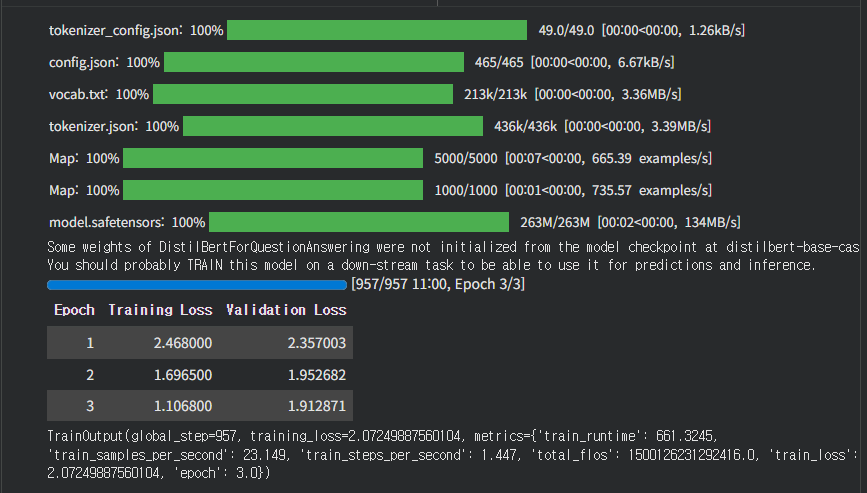

In [ ]:
print(squad) # 우리가 넣은 것 ???
print(train_dataset) # 모델이 원하는 형태 --> 전처리를 통해 이렇게 변경해줌.

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 5000
})
Dataset({
    features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 5103
})
